<a href="https://colab.research.google.com/github/llmoonstrucktravellerll/case-study/blob/main/case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library

In [2]:
# Import packages
import pandas as pd
import numpy as np
#from w2v_utils import *
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for styling

%matplotlib inline
import string
import re # regular expresson package
# Import NLP packages
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
# Import sklearn packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
import pickle
# Import keras for NN implementation
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# Train test split
from sklearn.model_selection import train_test_split
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

Load The Data Set


In [3]:
url = 'https://raw.githubusercontent.com/llmoonstrucktravellerll/case-study/main/spamraw.csv'
df = pd.read_csv(url)
msg_df=df
# rename the columns
df = df[['type','text']]
df.rename(columns={'type':'label', 'text':'message'}, inplace=True)
df.head()


,label,message
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
4,spam,okmail: Dear Dave this is your final notice to...


The summary statistics to better understand the data:



In [4]:
df.describe()


,label,message
count,5559,5559
unique,2,5156
top,ham,"Sorry, I'll call later"
freq,4812,30


In [5]:
df.groupby('label').describe().T


label                              ham  \
message count                     4812   
        unique                    4503   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

The distribution of ham and spam messages

Text(0.5, 1.0, 'The distribution of ham and spam messages')

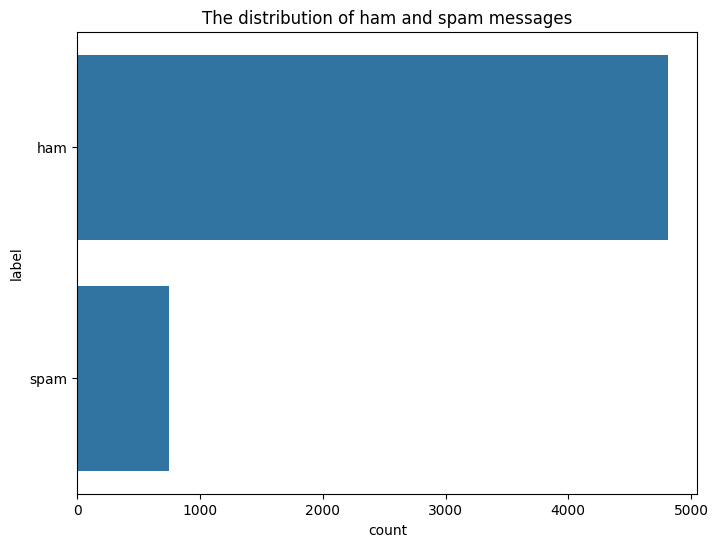

In [6]:
plt.figure(figsize=(8,6))
sns.countplot(df.label)
plt.title('The distribution of ham and spam messages')


**Text preprocessing**

Get length column for each text and convert the text label to numeric value:

In [7]:
# Assuming df is your DataFrame containing text messages and labels

# Add text length column for each text
df['text_length'] = df['message'].apply(len)

# Map label column to numeric values
df['msg_type'] = df['label'].map({'ham': 0, 'spam': 1})

# Extract numeric labels
msg_label = df['msg_type'].values

# Display the updated DataFrame
print(df.head())


  label                                            message  text_length  \
0   ham  Hope you are having a good week. Just checking in           49   
1   ham                            K..give back my thanks.           23   
2   ham        Am also doing in cbe only. But have to pay.           43   
3  spam  complimentary 4 STAR Ibiza Holiday or £10,000 ...          149   
4  spam  okmail: Dear Dave this is your final notice to...          161   

   msg_type  
0         0  
1         0  
2         0  
3         1  
4         1  


Train test split

In [8]:
x_train, x_test, y_train, y_test = train_test_split(df['message'], msg_label, test_size=0.2, random_state=434)

Tokenization

In [9]:
# Defining pre-processing parameters
max_len = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 500
tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

In [10]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

7984

Sequence and padding

In [11]:
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

In [12]:
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [13]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (4447, 50)
Shape of testing tensor:  (1112, 50)


Define the GRU model architecture:



In [14]:
embedding_dim = 10000  # You can adjust this value based on your needs

model3 = Sequential()
model3.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model3.add(SpatialDropout1D(0.2))
model3.add(GRU(128, return_sequences = False))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation = 'sigmoid'))

The summary of the model:



In [15]:
model3.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 10000)         5000000   
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 10000)         0         
 Dropout1D)                                                      
                                                                 
 gru (GRU)                   (None, 128)               3889920   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 8890049 (33.91 MB)
Trainable params: 8890049 (33.91 MB)
Non-trainable params: 0 (0.00 Byte)
________________

Compile the model:



In [16]:
model3.compile(loss = 'binary_crossentropy',
                       optimizer = 'adam',
                       metrics=['accuracy'])

Train the model:



In [17]:

num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model3.fit(training_padded,
                     y_train,
                     epochs=num_epochs,
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop],
                     verbose=2)

Epoch 1/30
139/139 - 264s - loss: 0.3729 - accuracy: 0.8752 - val_loss: 0.1219 - val_accuracy: 0.9586 - 264s/epoch - 2s/step
Epoch 2/30
139/139 - 253s - loss: 0.0771 - accuracy: 0.9786 - val_loss: 0.1159 - val_accuracy: 0.9667 - 253s/epoch - 2s/step
Epoch 3/30
139/139 - 259s - loss: 0.0397 - accuracy: 0.9892 - val_loss: 0.0780 - val_accuracy: 0.9793 - 259s/epoch - 2s/step
Epoch 4/30
139/139 - 258s - loss: 0.0280 - accuracy: 0.9919 - val_loss: 0.0758 - val_accuracy: 0.9820 - 258s/epoch - 2s/step
Epoch 5/30
139/139 - 250s - loss: 0.0146 - accuracy: 0.9957 - val_loss: 0.0987 - val_accuracy: 0.9766 - 250s/epoch - 2s/step
Epoch 6/30
139/139 - 236s - loss: 0.0084 - accuracy: 0.9984 - val_loss: 0.1283 - val_accuracy: 0.9703 - 236s/epoch - 2s/step


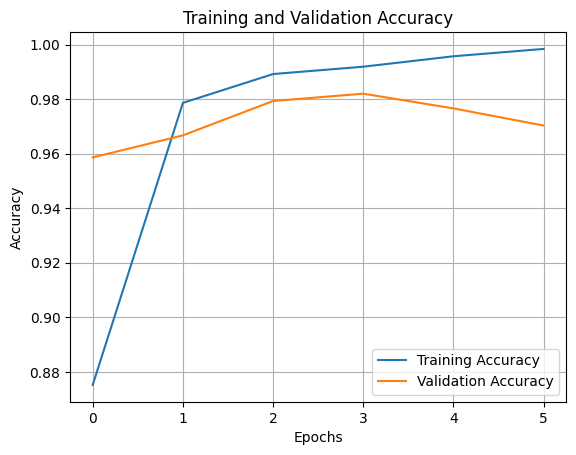

In [18]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the training history object returned by model.fit()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


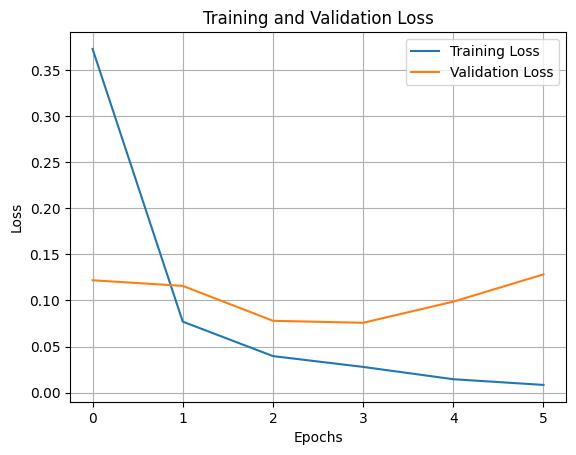

In [19]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the training history object returned by model.fit()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()
